![Logo BV IBMEC](https://raw.githubusercontent.com/ian-iania/IBMEC-BV-Modelos-Preditivos/main/logo-bv-ibmec-notebooks.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ian-iania/IBMEC-BV-Modelos-Preditivos/blob/main/notebooks/EX1_Committee_Cutoff_NoCode.ipynb)

# EX1 — Comitê de Crédito FP&A (BV): escolha de cutoff por custo (sem programar)

- escolher cutoff (política) a partir de probabilidade de default
- justificar usando volume aprovado, perda esperada e margem/oportunidade
- entender que cenário macro e apetite de risco mudam a decisão


## Enunciado do Exercício (para grupos de 3–4 pessoas)

Você está no comitê de crédito e precisa definir a política de cutoff para propostas PF.

- O modelo prevê **P(default 30+)**.
- A política transforma probabilidade em decisão:
  - `P >= cutoff` → negar/revisar
  - `P < cutoff` → aprovar
- Custos dos erros:
  - **FN** (aprovou quem virou default) → **Perda (FN)** = `loss_if_default`
  - **FP** (negou bom pagador) → **Margem perdida (FP)** = `profit_if_good`

### Tarefa do grupo (entregar em 3 bullets)
1. Cutoff escolhido + % Aprovados (volume)
2. Perda (FN), Margem perdida (FP) e Custo Total (R$)
3. Justificativa: cenário + apetite + modelo + 1 métrica (AUC ou PR-AUC) + trade-off FN vs FP

### Como rodar em 60 segundos
1. Ajuste as 3 variáveis (`scenario`, `risk_appetite`, `chosen_model`)
2. Clique em **Run all**
3. Vá para **✅ Resposta do Grupo** e copie os números


## 🔧 Config do Grupo (NÃO precisa programar)

Edite só estas 3 variáveis e rode tudo.


In [1]:
scenario = "BASE"            # opções: "BASE", "STRESS", "EXPANSAO"
risk_appetite = "BALANCEADO" # opções: "CONSERVADOR", "BALANCEADO", "AGRESSIVO"
chosen_model = "GBM"         # opções: "LOGISTICA", "GBM"


- `BASE`: cenário normal
- `STRESS`: cenário macro pior (aumenta risco)
- `EXPANSAO`: cenário favorável (reduz risco)
- `CONSERVADOR`: FN pesa mais
- `BALANCEADO`: pesos iguais
- `AGRESSIVO`: FP pesa mais
- `LOGISTICA`: mais explicável
- `GBM`: costuma separar melhor


## 1) Bibliotecas

Carregar bibliotecas para dados, modelos, métricas e gráficos.


In [2]:
import pandas as pd  # manipulação de tabelas
import numpy as np  # operações numéricas
import matplotlib.pyplot as plt  # gráficos simples (sanidade)
import matplotlib.ticker as mtick  # formatação percentual no eixo

from sklearn.compose import ColumnTransformer  # pré-processamento por tipo
from sklearn.preprocessing import OneHotEncoder, StandardScaler  # transformações
from sklearn.pipeline import Pipeline  # encadeia preprocess + modelo
from sklearn.linear_model import LogisticRegression  # modelo 1
from sklearn.ensemble import GradientBoostingClassifier  # modelo 2
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score  # ROC e PR
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix  # métricas de cutoff

import plotly.graph_objects as go  # gráficos principais interativos
from IPython.display import display, Markdown  # renderização de bloco-resumo em markdown

print('Bibliotecas carregadas.')  # confirmação rápida


Bibliotecas carregadas.


## 1.1) Formatação executiva das tabelas

A função abaixo padroniza todas as saídas para leitura rápida: moeda, percentual, inteiros e ordem de colunas.


In [3]:
def fmt_brl(v):  # formata número em moeda PT-BR sem casas
    return 'R$ ' + f'{float(v):,.0f}'.replace(',', 'X').replace('.', ',').replace('X', '.')


def fmt_pct(v):  # formata número decimal em percentual com 1 casa e vírgula
    return f'{float(v) * 100:.1f}%'.replace('.', ',')


def fmt_dec(v):  # formata métrica com 3 casas decimais e vírgula
    return f'{float(v):.3f}'.replace('.', ',')


def format_exec_table(df, column_order, rename_map, percent_cols=None, money_cols=None, int_cols=None, metric_cols=None):
    out = df.copy()  # cria cópia para não alterar tabela original
    percent_cols = percent_cols or []  # colunas percentuais
    money_cols = money_cols or []  # colunas monetárias
    int_cols = int_cols or []  # colunas inteiras
    metric_cols = metric_cols or []  # colunas de métricas com 3 casas

    for c in int_cols:
        out[c] = out[c].astype(int)  # força inteiro para colunas de contagem
    for c in percent_cols:
        out[c] = out[c].map(fmt_pct)  # aplica formato percentual
    for c in money_cols:
        out[c] = out[c].map(fmt_brl)  # aplica formato monetário
    for c in metric_cols:
        out[c] = out[c].map(fmt_dec)  # aplica formato decimal de métrica

    out = out[column_order].rename(columns=rename_map)  # reordena e renomeia colunas
    return out  # retorna tabela pronta para exibição


## 2) Carregar dataset

Carregamento direto via GitHub raw (ambiente controlado).


In [4]:
url = 'https://raw.githubusercontent.com/ian-iania/IBMEC-BV-Modelos-Preditivos/main/data/ex1_pf_committee.csv'  # fonte única

df = pd.read_csv(url)  # leitura direta do CSV

print('Fonte:', url)  # imprime origem
print(f'Shape: {df.shape[0]:,} linhas x {df.shape[1]} colunas')  # imprime tamanho


Fonte: https://raw.githubusercontent.com/ian-iania/IBMEC-BV-Modelos-Preditivos/main/data/ex1_pf_committee.csv
Shape: 12,000 linhas x 20 colunas


Agora vamos preparar o tempo e revisar uma amostra dos dados.


In [5]:
df['dt'] = pd.to_datetime(df['dt'])  # converte data para datetime

df = df.sort_values('dt').reset_index(drop=True)  # ordena por tempo

print(f'Default 30+ médio: {fmt_pct(df["default_30p"].mean())}')  # mostra prevalência

df.head(3)  # amostra inicial


Default 30+ médio: 10,2%


,id,dt,selic,idade,renda_mensal,score_interno,valor_solicitado,prazo_meses,taxa_mensal,parcela_mensal,pti,utilizacao_limite,atraso_antes_30d,atraso_antes_60d,canal,default_30p,ead,lgd,loss_if_default,profit_if_good
0,1,2019-01-01,6.922801,28,22989.290280,501,67670.397583,24,0.016857,3451.698320,0.150144,0.925724,0,0,digital,0,47369.278308,0.526085,24920.243160,5475.487577
1,2,2019-01-01,7.454672,36,5904.850437,604,17857.929517,48,0.014363,517.468625,0.087635,0.124067,0,0,agencia,0,12500.550662,0.250000,3125.137665,2462.306413
2,3,2019-01-01,7.073114,28,4359.502225,621,15668.297239,48,0.014492,455.281171,0.104434,0.420939,0,0,parceiro,0,10967.808067,0.562793,6172.609271,2179.837836


### Sanidade rápida 1 — taxa de Default 30+

O que observar: classe positiva é menor.


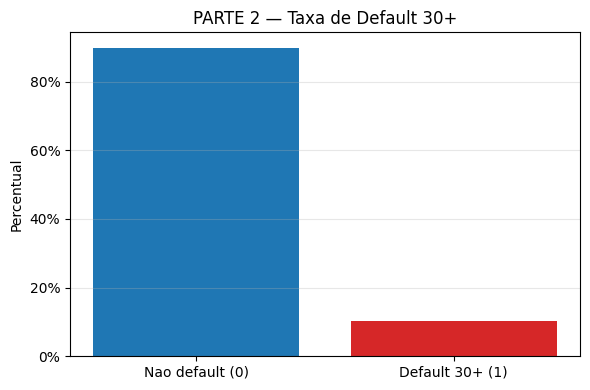

In [6]:
class_rate = df['default_30p'].value_counts(normalize=True).sort_index()  # calcula proporção por classe

fig, ax = plt.subplots(figsize=(6, 4))  # cria figura
ax.bar(['Nao default (0)', 'Default 30+ (1)'], class_rate.values, color=['#1f77b4', '#d62728'])  # plota barras
ax.set_title('PARTE 2 — Taxa de Default 30+')  # título
ax.set_ylabel('Percentual')  # eixo Y
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))  # formato percentual
ax.grid(axis='y', alpha=0.3)  # grade
plt.tight_layout()  # layout
plt.show()  # exibe


### Sanidade rápida 2 — histograma de PTI

O que observar: concentração de comprometimento de renda.


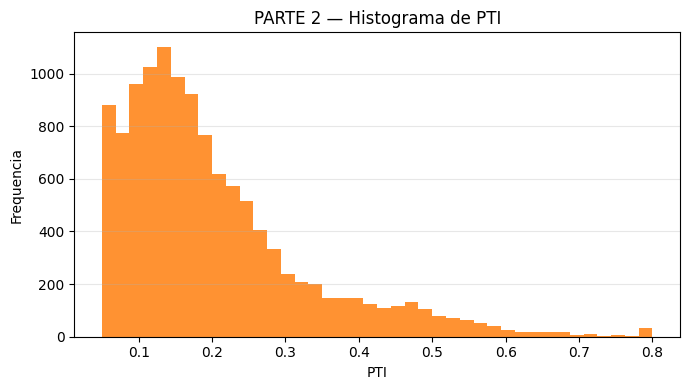

In [7]:
fig, ax = plt.subplots(figsize=(7, 4))  # cria figura
ax.hist(df['pti'], bins=40, color='#ff7f0e', alpha=0.85)  # histograma PTI
ax.set_title('PARTE 2 — Histograma de PTI')  # título
ax.set_xlabel('PTI')  # eixo X
ax.set_ylabel('Frequencia')  # eixo Y
ax.grid(axis='y', alpha=0.3)  # grade
plt.tight_layout()  # layout
plt.show()  # exibe


### Sanidade rápida 3 — histograma de score interno

O que observar: distribuição do score da carteira.


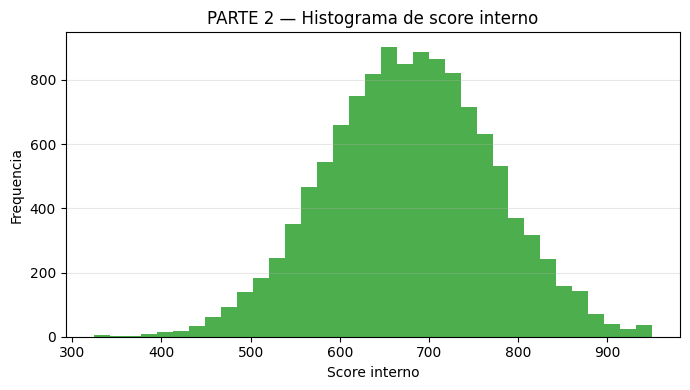

In [8]:
fig, ax = plt.subplots(figsize=(7, 4))  # cria figura
ax.hist(df['score_interno'], bins=35, color='#2ca02c', alpha=0.85)  # histograma score
ax.set_title('PARTE 2 — Histograma de score interno')  # título
ax.set_xlabel('Score interno')  # eixo X
ax.set_ylabel('Frequencia')  # eixo Y
ax.grid(axis='y', alpha=0.3)  # grade
plt.tight_layout()  # layout
plt.show()  # exibe


## 3) Split temporal (80/20)

Sem embaralhar: treino no passado e teste no futuro.


In [9]:
split_idx = int(len(df) * 0.8)  # calcula índice do corte temporal

train = df.iloc[:split_idx].copy().reset_index(drop=True)  # fatia treino

test = df.iloc[split_idx:].copy().reset_index(drop=True)  # fatia teste

split_raw = pd.DataFrame({  # resumo bruto do split
    'bloco': ['Treino', 'Teste'],
    'linhas': [len(train), len(test)],
    'inicio': [train['dt'].min().date(), test['dt'].min().date()],
    'fim': [train['dt'].max().date(), test['dt'].max().date()],
    'default_30p': [train['default_30p'].mean(), test['default_30p'].mean()],
})

split_view = split_raw.copy()  # cópia para exibição formatada
split_view['default_30p'] = split_view['default_30p'].map(fmt_pct)  # formata taxa de default
split_view.rename(columns={'default_30p': 'Default 30+'}, inplace=True)  # padroniza nomenclatura

split_view  # exibe resumo do split


,bloco,linhas,inicio,fim,Default 30+
0,Treino,9600,2019-01-01,2023-10-10,"9,4%"
1,Teste,2400,2023-10-10,2024-12-31,"13,4%"


## 4) Treinar Logística e GBM

Mesmas features e mesmo split para comparação justa.


In [10]:
num_features = [  # variáveis numéricas de entrada
    'selic', 'idade', 'renda_mensal', 'score_interno', 'valor_solicitado',
    'prazo_meses', 'taxa_mensal', 'parcela_mensal', 'pti',
    'utilizacao_limite', 'atraso_antes_30d', 'atraso_antes_60d'
]
cat_features = ['canal']  # variável categórica

X_train = train[num_features + cat_features].copy()  # matriz treino
X_test = test[num_features + cat_features].copy()  # matriz teste
y_train = train['default_30p'].copy()  # alvo treino
y_test = test['default_30p'].copy()  # alvo teste


Agora definimos o pipeline de pré-processamento + Logística.


In [11]:
prep = ColumnTransformer(  # define transformações por tipo
    transformers=[
        ('num', StandardScaler(), num_features),  # padroniza numéricas
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),  # one-hot das categóricas
    ]
)

pipe_log = Pipeline(  # pipeline da logística
    steps=[('prep', prep), ('model', LogisticRegression(max_iter=2000, random_state=42))]
)

pipe_log.fit(X_train, y_train)  # treina logística
proba_log = pipe_log.predict_proba(X_test)[:, 1]  # probabilidade no teste


Agora treinamos o GBM no mesmo setup.


In [12]:
pipe_gbm = Pipeline(  # pipeline do GBM
    steps=[('prep', prep), ('model', GradientBoostingClassifier(random_state=42))]
)

pipe_gbm.fit(X_train, y_train)  # treina GBM
proba_gbm = pipe_gbm.predict_proba(X_test)[:, 1]  # probabilidade no teste

proba_test_models = {'LOGISTICA': proba_log, 'GBM': proba_gbm}  # dicionário final de probabilidades


## 5) Cenário via ajuste de odds (sem re-treinar)

Lógica do exercício: ajustar risco por cenário macro usando multiplicador de odds.


In [13]:
scenario_multiplier_map = {'BASE': 1.00, 'STRESS': 1.35, 'EXPANSAO': 0.85}  # multiplicadores de cenário
mult = scenario_multiplier_map[scenario]  # seleciona multiplicador do cenário

proba_base = np.clip(proba_test_models[chosen_model], 1e-6, 1 - 1e-6)  # probabilidade base com proteção numérica
odds = proba_base / (1 - proba_base)  # converte para odds
odds_adj = odds * mult  # aplica cenário nas odds
proba_test_adj = odds_adj / (1 + odds_adj)  # converte de volta para probabilidade

print(f'Cenario: {scenario} | multiplicador={mult:.2f}')  # resumo do cenário aplicado
print(f'Prob média antes={proba_base.mean():.4f} | depois={proba_test_adj.mean():.4f}')  # efeito agregado


Cenario: BASE | multiplicador=1.00
Prob média antes=0.1252 | depois=0.1252


## 6) Apetite de risco via pesos de custo

Lógica do exercício: pesos diferentes para Perda (FN) e Margem perdida (FP).


In [14]:
risk_weights_map = {  # pesos por perfil de apetite
    'CONSERVADOR': {'w_fn': 1.20, 'w_fp': 0.80},
    'BALANCEADO': {'w_fn': 1.00, 'w_fp': 1.00},
    'AGRESSIVO': {'w_fn': 0.90, 'w_fp': 1.20},
}

w_fn = risk_weights_map[risk_appetite]['w_fn']  # peso da Perda (FN)
w_fp = risk_weights_map[risk_appetite]['w_fp']  # peso da Margem perdida (FP)

print(f'Apetite: {risk_appetite} | w_fn={w_fn:.2f} | w_fp={w_fp:.2f}')  # resumo dos pesos


Apetite: BALANCEADO | w_fn=1.00 | w_fp=1.00


📌 AUC/PR-AUC mede separação do MODELO (ranking). Não define política.

## 7) ROC e PR do modelo escolhido (Plotly)

Curvas de separação do modelo com cenário/apetite aplicados.


In [15]:
fpr, tpr, _ = roc_curve(y_test, proba_test_adj)  # pontos ROC
auc_val = roc_auc_score(y_test, proba_test_adj)  # AUC

fig_roc = go.Figure()  # figura ROC
fig_roc.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'{chosen_model} (AUC={auc_val:.3f})'))  # curva ROC
fig_roc.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Aleatorio', line=dict(dash='dash')))  # diagonal
fig_roc.update_layout(  # título com contexto completo
    title=f'ROC — {chosen_model} | {scenario} | {risk_appetite} | AUC={auc_val:.3f}',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
)
fig_roc.show()  # exibe


plotly figure rendered (stub)


Agora a curva PR do mesmo modelo/contexto.


In [16]:
precision_arr, recall_arr, _ = precision_recall_curve(y_test, proba_test_adj)  # pontos PR
pr_auc_val = average_precision_score(y_test, proba_test_adj)  # PR-AUC

fig_pr = go.Figure()  # figura PR
fig_pr.add_trace(go.Scatter(x=recall_arr, y=precision_arr, mode='lines', name=f'{chosen_model} (PR-AUC={pr_auc_val:.3f})'))  # curva PR
fig_pr.update_layout(  # título com contexto completo
    title=f'Precision-Recall — {chosen_model} | {scenario} | {risk_appetite} | PR-AUC={pr_auc_val:.3f}',
    xaxis_title='Recall',
    yaxis_title='Precision',
)
fig_pr.show()  # exibe


plotly figure rendered (stub)


📌 Cutoff transforma probabilidade em DECISÃO. Precision/Recall/F1 mudam com cutoff.

## 8) Cutoffs didáticos (10/20/30)

Vamos comparar 3 políticas simples.


In [17]:
def eval_cutoff(y_true, y_proba, test_df, cutoff, w_fn, w_fp):  # avalia métricas e custo em um cutoff
    y_pred = (y_proba >= cutoff).astype(int)  # decisão binária
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()  # matriz de confusão

    mask_fp = (y_true.values == 0) & (y_pred == 1)  # identifica FP
    mask_fn = (y_true.values == 1) & (y_pred == 0)  # identifica FN

    custo_fp = test_df.loc[mask_fp, 'profit_if_good'].sum()  # soma Margem perdida (FP)
    custo_fn = test_df.loc[mask_fn, 'loss_if_default'].sum()  # soma Perda (FN)

    return {
        'cutoff': cutoff,
        'aprovacao_pct': (y_pred == 0).mean(),
        'FP': int(fp),
        'FN': int(fn),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'custo_fp_R$': float(custo_fp),
        'custo_fn_R$': float(custo_fn),
        'custo_total_R$': float(w_fp * custo_fp + w_fn * custo_fn),
    }


Aplicar a função para 10%, 20% e 30%.


In [18]:
cutoffs_fixos = [0.10, 0.20, 0.30]  # cutoffs didáticos
rows_3 = [eval_cutoff(y_test, proba_test_adj, test, c, w_fn, w_fp) for c in cutoffs_fixos]  # avaliação dos 3 cenários
cutoff_3_df = pd.DataFrame(rows_3)  # tabela bruta


Tabela executiva dos 3 cutoffs (formato com R$, %, inteiros e métricas).


In [19]:
order_cut = ['cutoff', 'aprovacao_pct', 'FP', 'FN', 'precision', 'recall', 'f1', 'custo_fp_R$', 'custo_fn_R$', 'custo_total_R$']  # ordem padrão
rename_cut = {  # nomes executivos em português
    'cutoff': 'Cutoff',
    'aprovacao_pct': '% Aprovados (volume)',
    'FP': 'FP',
    'FN': 'FN',
    'precision': 'Precision',
    'recall': 'Recall',
    'f1': 'F1',
    'custo_fp_R$': 'Margem perdida (FP) (R$)',
    'custo_fn_R$': 'Perda (FN) (R$)',
    'custo_total_R$': 'Custo Total (R$)',
}

cutoff_3_view = format_exec_table(  # aplica padrão executivo
    cutoff_3_df,
    column_order=order_cut,
    rename_map=rename_cut,
    percent_cols=['cutoff', 'aprovacao_pct'],
    money_cols=['custo_fp_R$', 'custo_fn_R$', 'custo_total_R$'],
    int_cols=['FP', 'FN'],
    metric_cols=['precision', 'recall', 'f1'],
)

cutoff_3_view  # exibe tabela final


,Cutoff,% Aprovados (volume),FP,FN,Precision,Recall,F1,Margem perdida (FP) (R$),Perda (FN) (R$),Custo Total (R$)
0,"10,0%","66,0%",590,94,"0,278","0,707","0,399",R$ 1.636.064,R$ 933.776,R$ 2.569.840
1,"20,0%","83,8%",221,153,"0,432","0,523","0,473",R$ 617.630,R$ 1.473.059,R$ 2.090.689
2,"30,0%","90,3%",107,196,"0,539","0,389","0,452",R$ 293.324,R$ 1.849.122,R$ 2.142.446


Barras de custo para os 3 cutoffs.


In [20]:
fig_cut3 = go.Figure()  # figura de barras
fig_cut3.add_trace(go.Bar(  # barras com rótulo de valor
    x=[f'{int(c*100)}%' for c in cutoff_3_df['cutoff']],
    y=cutoff_3_df['custo_total_R$'],
    text=[fmt_brl(v) for v in cutoff_3_df['custo_total_R$']],
    textposition='outside',
    name='Custo Total (R$)',
))
fig_cut3.update_layout(  # layout do gráfico
    title=f'Custo total (10/20/30) — {chosen_model} | {scenario} | {risk_appetite}',
    xaxis_title='Cutoff',
    yaxis_title='Custo Total (R$)',
)
fig_cut3.show()  # exibe


plotly figure rendered (stub)


📌 Em FP&A, o PAYOFF é R$: FN = perda; FP = margem/oportunidade perdida.

## 9) Grid de cutoffs (5% a 50%)

Agora buscamos o menor custo total em uma faixa maior de políticas.


In [21]:
cutoff_grid = np.arange(0.05, 0.51, 0.05)  # grade 5%..50%
rows_grid = [eval_cutoff(y_test, proba_test_adj, test, c, w_fn, w_fp) for c in cutoff_grid]  # avalia cada cutoff
grid_df = pd.DataFrame(rows_grid)  # tabela bruta do grid

grid_sorted = grid_df.sort_values('custo_total_R$').reset_index(drop=True)  # ordena por menor custo
best_row = grid_sorted.iloc[0].copy()  # melhor cutoff
second_row = grid_sorted.iloc[1].copy()  # segundo melhor cutoff


Aplicar formatação executiva na tabela principal do grid.


In [22]:
grid_view = format_exec_table(  # tabela do grid formatada
    grid_sorted,
    column_order=order_cut,
    rename_map=rename_cut,
    percent_cols=['cutoff', 'aprovacao_pct'],
    money_cols=['custo_fp_R$', 'custo_fn_R$', 'custo_total_R$'],
    int_cols=['FP', 'FN'],
    metric_cols=['precision', 'recall', 'f1'],
)

grid_view.head(10)  # exibe top 10 por menor custo


,Cutoff,% Aprovados (volume),FP,FN,Precision,Recall,F1,Margem perdida (FP) (R$),Perda (FN) (R$),Custo Total (R$)
0,"20,0%","83,8%",221,153,"0,432","0,523","0,473",R$ 617.630,R$ 1.473.059,R$ 2.090.689
1,"25,0%","87,5%",155,177,"0,482","0,449","0,465",R$ 443.379,R$ 1.688.842,R$ 2.132.221
2,"30,0%","90,3%",107,196,"0,539","0,389","0,452",R$ 293.324,R$ 1.849.122,R$ 2.142.446
3,"35,0%","92,0%",81,210,"0,578","0,346","0,433",R$ 231.734,R$ 1.969.140,R$ 2.200.874
4,"40,0%","93,3%",62,222,"0,615","0,308","0,411",R$ 175.708,R$ 2.056.122,R$ 2.231.830
5,"15,0%","77,9%",336,127,"0,366","0,604","0,456",R$ 973.711,R$ 1.295.681,R$ 2.269.391
6,"45,0%","94,7%",46,239,"0,641","0,255","0,365",R$ 133.827,R$ 2.231.414,R$ 2.365.241
7,"50,0%","95,7%",33,250,"0,683","0,221","0,334",R$ 95.681,R$ 2.321.748,R$ 2.417.430
8,"10,0%","66,0%",590,94,"0,278","0,707","0,399",R$ 1.636.064,R$ 933.776,R$ 2.569.840
9,"5,0%","35,3%",1258,27,"0,189","0,916","0,314",R$ 3.242.730,R$ 276.540,R$ 3.519.269


### ✅ Melhor cutoff (menor custo total)

A linha vencedora é destacada abaixo com números prontos para discussão.


In [23]:
display(Markdown(
    f"✅ Melhor cutoff (menor custo total) = **{fmt_pct(best_row['cutoff'])}**  \n"
    f"Aprovação = **{fmt_pct(best_row['aprovacao_pct'])}** | "
    f"Custo total = **{fmt_brl(best_row['custo_total_R$'])}** | "
    f"FN = **{int(best_row['FN'])}** | FP = **{int(best_row['FP'])}**"
))  # renderiza resumo vencedor em markdown


✅ Melhor cutoff (menor custo total) = **20,0%**  
Aprovação = **83,8%** | Custo total = **R$ 2.090.689** | FN = **153** | FP = **221**

Mini-tabela do vencedor e do segundo melhor (para discussão em sala).


In [24]:
winner_df = pd.DataFrame([best_row, second_row]).reset_index(drop=True)  # monta top-2
winner_df.index = ['Vencedor', '2º melhor']  # rótulos das linhas

winner_view = format_exec_table(  # formata top-2 em padrão executivo
    winner_df.reset_index().rename(columns={'index': 'rank'}),
    column_order=['rank'] + order_cut,
    rename_map={'rank': 'Posição', **rename_cut},
    percent_cols=['cutoff', 'aprovacao_pct'],
    money_cols=['custo_fp_R$', 'custo_fn_R$', 'custo_total_R$'],
    int_cols=['FP', 'FN'],
    metric_cols=['precision', 'recall', 'f1'],
)

winner_view  # exibe tabela top-2


,Posição,Cutoff,% Aprovados (volume),FP,FN,Precision,Recall,F1,Margem perdida (FP) (R$),Perda (FN) (R$),Custo Total (R$)
0,Vencedor,"20,0%","83,8%",221,153,"0,432","0,523","0,473",R$ 617.630,R$ 1.473.059,R$ 2.090.689
1,2º melhor,"25,0%","87,5%",155,177,"0,482","0,449","0,465",R$ 443.379,R$ 1.688.842,R$ 2.132.221


Curva de custo total com destaque visual do melhor cutoff.


In [25]:
custom_data = np.column_stack([grid_df['aprovacao_pct'], grid_df['FN'], grid_df['FP']])  # dados extras do hover

fig_grid = go.Figure()  # figura custo x cutoff
fig_grid.add_trace(go.Scatter(  # curva principal com hover detalhado
    x=grid_df['cutoff'],
    y=grid_df['custo_total_R$'],
    mode='lines+markers',
    name='Custo Total (R$)',
    customdata=custom_data,
    hovertemplate=(
        'Cutoff=%{x:.0%}<br>'
        'Custo Total=%{y:,.0f}<br>'
        '% Aprovados=%{customdata[0]:.1%}<br>'
        'FN=%{customdata[1]:.0f}<br>'
        'FP=%{customdata[2]:.0f}<extra></extra>'
    ),
))

fig_grid.add_vline(x=float(best_row['cutoff']), line_dash='dash', line_color='red')  # linha vertical no cutoff ótimo
fig_grid.add_annotation(  # anotação textual do melhor ponto
    x=float(best_row['cutoff']),
    y=float(best_row['custo_total_R$']),
    text=f"Melhor cutoff: {fmt_pct(best_row['cutoff'])}",
    showarrow=True,
    arrowhead=2,
)

fig_grid.update_layout(  # layout final
    title=f'Custo Total (R$) vs Cutoff — {chosen_model} | {scenario} | {risk_appetite}',
    xaxis_title='Cutoff (%)',
    yaxis_title='Custo Total (R$)',
)
fig_grid.show()  # exibe


plotly figure rendered (stub)


## 10) Gains / Lift por decil (Plotly)

Ranking prático: decil 1 concentra os clientes com maior risco previsto.


In [26]:
rank_df = pd.DataFrame({'Default 30+': y_test.values, 'proba': proba_test_adj})  # base para ranking
rank_df = rank_df.sort_values('proba', ascending=False).reset_index(drop=True)  # ordena por risco
rank_df['decil'] = pd.qcut(rank_df.index + 1, 10, labels=False) + 1  # cria 10 decis

lift_df = rank_df.groupby('decil', as_index=False).agg(  # agrega métricas por decil
    n=('Default 30+', 'size'),
    defaults=('Default 30+', 'sum'),
)
lift_df['taxa_default'] = lift_df['defaults'] / lift_df['n']  # taxa de default por decil
lift_df['pct_acumulado_defaults'] = lift_df['defaults'].cumsum() / lift_df['defaults'].sum()  # ganho acumulado


Tabela por decil em formato executivo.


In [27]:
lift_view = format_exec_table(  # aplica formato no lift
    lift_df,
    column_order=['decil', 'n', 'defaults', 'taxa_default', 'pct_acumulado_defaults'],
    rename_map={
        'decil': 'Decil',
        'n': 'N',
        'defaults': 'Default 30+ (qtd)',
        'taxa_default': 'Taxa de Default 30+',
        'pct_acumulado_defaults': '% acumulado de defaults',
    },
    percent_cols=['taxa_default', 'pct_acumulado_defaults'],
    int_cols=['decil', 'n', 'defaults'],
)

lift_view  # exibe tabela formatada


,Decil,N,Default 30+ (qtd),Taxa de Default 30+,% acumulado de defaults
0,1,240,127,"52,9%","39,6%"
1,2,240,60,"25,0%","58,3%"
2,3,240,31,"12,9%","67,9%"
3,4,240,24,"10,0%","75,4%"
4,5,240,22,"9,2%","82,2%"
5,6,240,26,"10,8%","90,3%"
6,7,240,9,"3,8%","93,1%"
7,8,240,10,"4,2%","96,3%"
8,9,240,9,"3,8%","99,1%"
9,10,240,3,"1,2%","100,0%"


Barras: taxa de default por decil.


In [28]:
fig_lift_bar = go.Figure()  # figura de barras
fig_lift_bar.add_trace(go.Bar(x=lift_df['decil'], y=lift_df['taxa_default'], name='Taxa de Default 30+'))  # barras por decil
fig_lift_bar.update_layout(  # layout
    title=f'Lift por decil — {chosen_model} | {scenario} | {risk_appetite}',
    xaxis_title='Decil (1 = mais risco)',
    yaxis_title='Taxa de Default 30+',
)
fig_lift_bar.show()  # exibe


plotly figure rendered (stub)


Linha: % acumulado de defaults capturados.


In [29]:
fig_gains = go.Figure()  # figura de linha
fig_gains.add_trace(go.Scatter(x=lift_df['decil'], y=lift_df['pct_acumulado_defaults'], mode='lines+markers', name='% acumulado defaults'))  # curva gains
fig_gains.update_layout(  # layout
    title=f'Gains acumulados — {chosen_model} | {scenario} | {risk_appetite}',
    xaxis_title='Decil (1 = mais risco)',
    yaxis_title='% acumulado de defaults',
)
fig_gains.show()  # exibe


plotly figure rendered (stub)


## ✅ Resposta do Grupo (copiar e colar)

Preencha com os números do notebook:

- **Modelo + cenário + apetite:** ____ | ____ | ____  
  **Cutoff escolhido:** __% | **% Aprovados (volume):** __%
- **Impacto financeiro (TESTE):** **Perda (FN)** = R$ __ | **Margem perdida (FP)** = R$ __ | **Custo Total (R$)** = R$ __
- **Justificativa (3 bullets curtos):**
  1. Métrica obrigatória: AUC ou PR-AUC = ____ (1 frase)
  2. Trade-off explícito: FN vs FP (por que este cutoff)
  3. Governança: por que Logística **ou** por que GBM neste contexto


## 12) Fechamento executivo

- Modelo: separação (AUC/PR-AUC)
- Política: cutoff (decisão)
- FP&A: payoff em R$ (Custo Total)
- Cenário e apetite mudam o cutoff ótimo
- Logística é mais explicável; GBM pode performar melhor (governança maior)
